In [19]:

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from PIL import Image


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [9]:
data_dir = './defungi'  #dataset path

In [10]:
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATES = [0.0001, 0.001, 0.01, 0.1]
KERNEL_SIZE = 3
POOL_SIZE = 2

In [11]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalizing to [-1, 1]
])

In [12]:
dataset = datasets.ImageFolder(data_dir, transform=transform)
class_names = dataset.classes

In [13]:
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

In [14]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


In [16]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=KERNEL_SIZE, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=POOL_SIZE, stride=2),

            nn.Conv2d(32, 64, kernel_size=KERNEL_SIZE, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=POOL_SIZE, stride=2),

            nn.Conv2d(64, 128, kernel_size=KERNEL_SIZE, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=POOL_SIZE, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * (IMG_SIZE // 8) * (IMG_SIZE // 8), 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, len(dataset.classes))
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [14]:
def train_and_validate_model(learning_rate):
    model = CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    for epoch in range(EPOCHS):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_losses.append(running_val_loss / len(val_loader))

        print(f"Learning Rate: {learning_rate}, Epoch [{epoch+1}/{EPOCHS}], Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {running_val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return train_losses, val_losses, model

In [15]:
def test_model(model):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print("Confusion Matrix:\n", cm)

    # Classification Report
    class_report = classification_report(all_labels, all_predictions, target_names=dataset.classes, zero_division=0)
    print("Classification Report:\n", class_report)

In [16]:
def plot_training_curves_separately(losses, learning_rates):
    for lr, (train_losses, val_losses) in losses.items():
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(train_losses) + 1), train_losses, label=f"Train Loss")
        plt.plot(range(1, len(val_losses) + 1), val_losses, label=f"Val Loss")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Training and Validation Loss (LR={lr})')
        plt.legend()
        plt.grid()
        plt.show()

In [17]:
def predict_image(image_path, model, class_names):
    model.eval()
    image = Image.open(image_path)

    transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted_class = torch.max(output, 1)
        return class_names[predicted_class.item()]

Learning Rate: 0.0001, Epoch [1/20], Train Loss: 1.1347, Train Accuracy: 54.79%, Val Loss: 1.0040, Val Accuracy: 59.39%
Learning Rate: 0.0001, Epoch [2/20], Train Loss: 0.9475, Train Accuracy: 61.52%, Val Loss: 0.8959, Val Accuracy: 64.71%
Learning Rate: 0.0001, Epoch [3/20], Train Loss: 0.8909, Train Accuracy: 63.79%, Val Loss: 0.8540, Val Accuracy: 65.97%
Learning Rate: 0.0001, Epoch [4/20], Train Loss: 0.8540, Train Accuracy: 64.94%, Val Loss: 0.8298, Val Accuracy: 66.58%
Learning Rate: 0.0001, Epoch [5/20], Train Loss: 0.8221, Train Accuracy: 66.88%, Val Loss: 0.8351, Val Accuracy: 65.92%
Learning Rate: 0.0001, Epoch [6/20], Train Loss: 0.7880, Train Accuracy: 67.90%, Val Loss: 0.8089, Val Accuracy: 65.97%
Learning Rate: 0.0001, Epoch [7/20], Train Loss: 0.7774, Train Accuracy: 68.40%, Val Loss: 0.7815, Val Accuracy: 68.00%
Learning Rate: 0.0001, Epoch [8/20], Train Loss: 0.7524, Train Accuracy: 69.29%, Val Loss: 0.7861, Val Accuracy: 67.51%
Learning Rate: 0.0001, Epoch [9/20], Tra

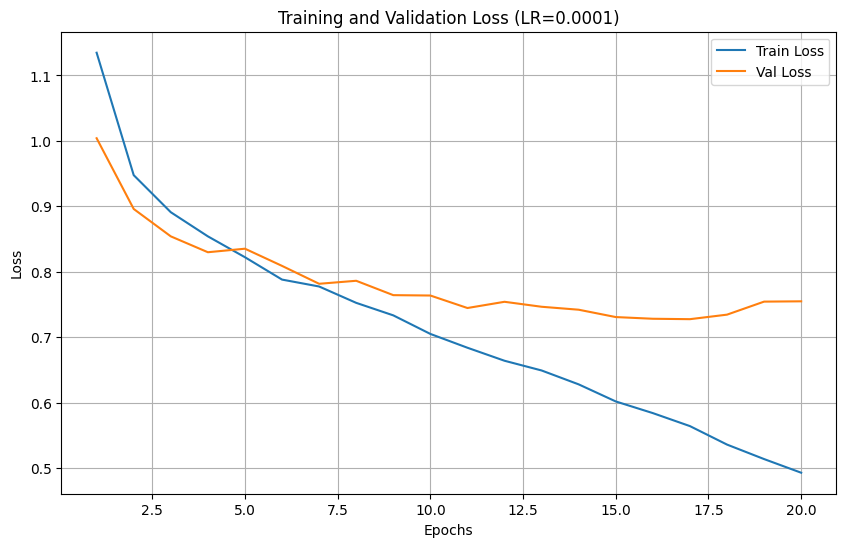

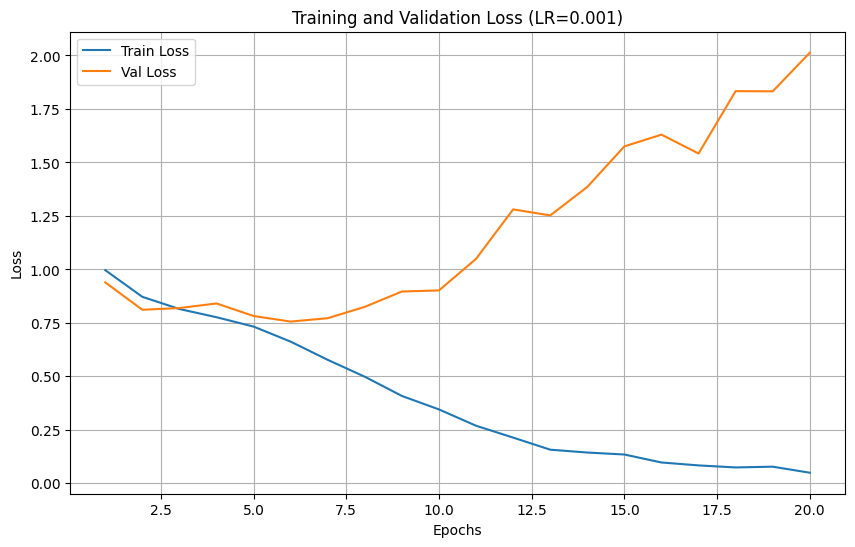

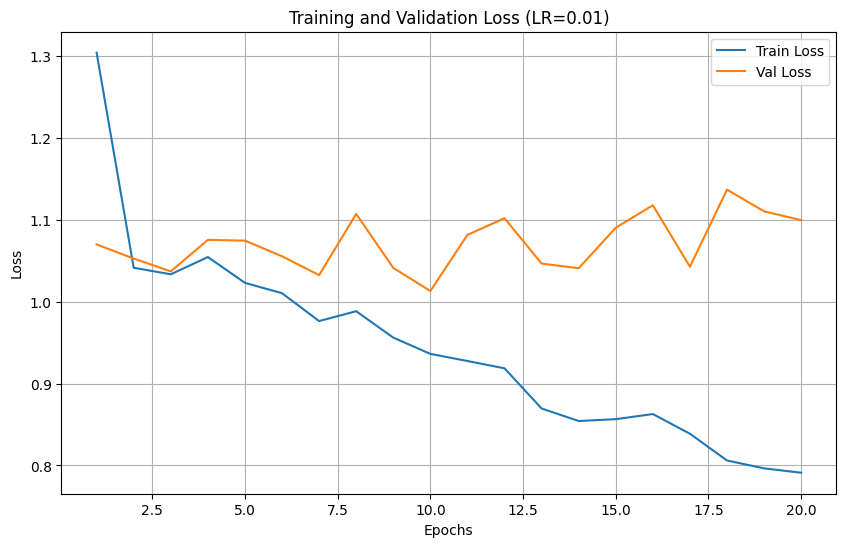

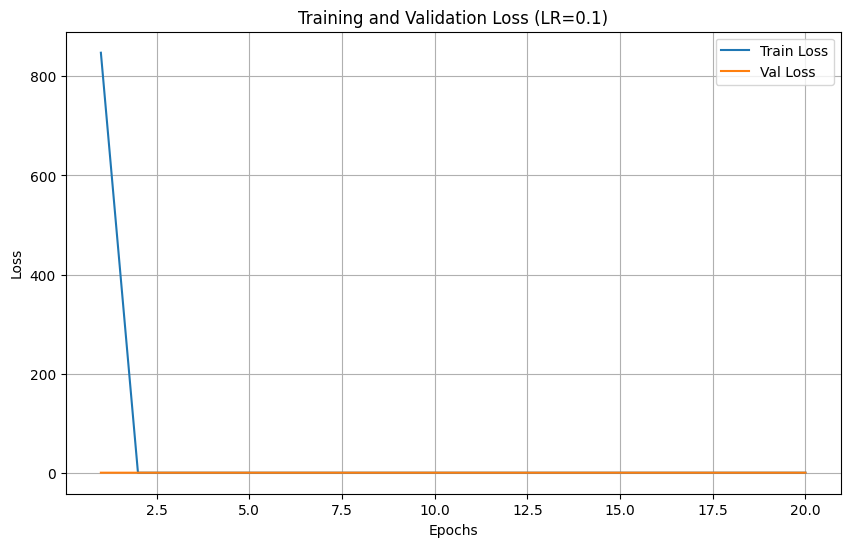

In [18]:
all_losses = {}
for lr in LEARNING_RATES:
    train_losses, val_losses, trained_model = train_and_validate_model(lr)
    all_losses[lr] = (train_losses, val_losses)

    # Test the final model for this learning rate
    print(f"\nTesting model trained with learning rate {lr}")
    test_model(trained_model)

# Plot training curves separately for each learning rate
plot_training_curves_separately(all_losses, LEARNING_RATES)

In [4]:
def train_and_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [5]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct / total
    print(f"Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return test_accuracy, all_predictions, all_labels

In [18]:
num_classes = len(dataset.classes)

In [20]:
# 1. ResNet
resnet = models.resnet18(pretrained=True)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)
resnet = resnet.to(device)

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:59<00:00, 789kB/s] 


In [22]:

lr=0.0001
print(f"\nTraining ResNet with Learning Rate: {lr}")
optimizer_resnet = optim.Adam(resnet.parameters(), lr=lr)
resnet, train_losses, val_losses, _, _ = train_and_validate_model(resnet, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_resnet, num_epochs=10)


# Evaluate the model on the test set
criterion = nn.CrossEntropyLoss()
test_accuracy, predictions, labels = test_model(resnet, test_loader, criterion)


Training ResNet with Learning Rate: 0.0001
Epoch 1/10, Train Loss: 0.6591, Train Accuracy: 73.99%, Val Loss: 0.4925, Val Accuracy: 81.12%
Epoch 2/10, Train Loss: 0.2413, Train Accuracy: 91.84%, Val Loss: 0.5291, Val Accuracy: 81.67%
Epoch 3/10, Train Loss: 0.0982, Train Accuracy: 96.85%, Val Loss: 0.5417, Val Accuracy: 84.96%
Epoch 4/10, Train Loss: 0.0478, Train Accuracy: 98.72%, Val Loss: 0.5003, Val Accuracy: 84.80%
Epoch 5/10, Train Loss: 0.0501, Train Accuracy: 98.34%, Val Loss: 0.6053, Val Accuracy: 83.26%
Epoch 6/10, Train Loss: 0.0466, Train Accuracy: 98.41%, Val Loss: 0.5337, Val Accuracy: 83.48%
Epoch 7/10, Train Loss: 0.0552, Train Accuracy: 98.26%, Val Loss: 0.7088, Val Accuracy: 82.27%
Epoch 8/10, Train Loss: 0.0767, Train Accuracy: 97.48%, Val Loss: 0.5108, Val Accuracy: 85.57%
Epoch 9/10, Train Loss: 0.0368, Train Accuracy: 98.90%, Val Loss: 0.5195, Val Accuracy: 85.84%
Epoch 10/10, Train Loss: 0.0281, Train Accuracy: 99.10%, Val Loss: 0.6400, Val Accuracy: 83.70%
Test 

In [24]:
densenet = models.densenet121(pretrained=True)
densenet.classifier = nn.Linear(densenet.classifier.in_features, num_classes)
densenet = densenet.to(device)

C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:31<00:00, 1.02MB/s]


In [ ]:
print(f"\nTraining DenseNet with Learning Rate: {lr}")

optimizer_densenet = optim.Adam(densenet.parameters(), lr=lr)
densenet, train_losses2, val_losses2, _, _ = train_and_validate_model(densenet, train_loader, val_loader, criterion, optimizer_densenet, num_epochs=10)

# Evaluate the model on the test set
test_accuracy2, predictions2, labels2 = test_model(densenet, test_loader, criterion)


Training DenseNet with Learning Rate: 0.0001
